# Warm up session
1. Load the time series 'MBA_ECG14046_data_22.out' from the ECG dataset
2. Plot the time series from the dataset
3. Highlight the anomalies in red
4. Find the average number of anomalies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time

## Load the time series

In [2]:
# Paths & Directories
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public', 'ECG')
file_name = 'MBA_ECG803_data.out'
file_path = os.path.join(dataset_path, file_name)

In [3]:
# Load the timeseries
df = pd.read_csv(file_path, header=None)
data = df[0].to_numpy()
label = df[1].to_numpy()

## Plot the time series and its anomalies

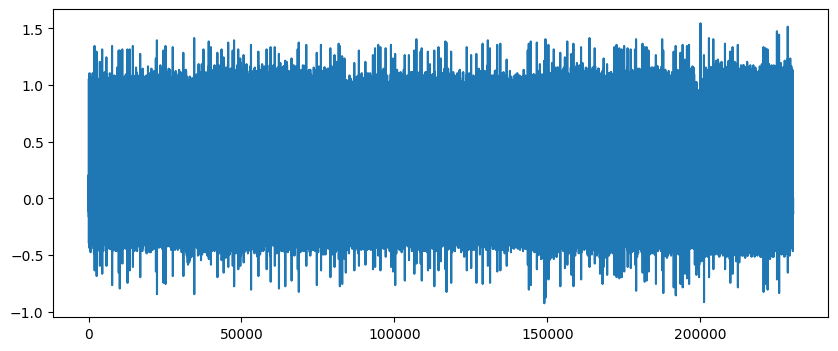

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(data)
plt.show()

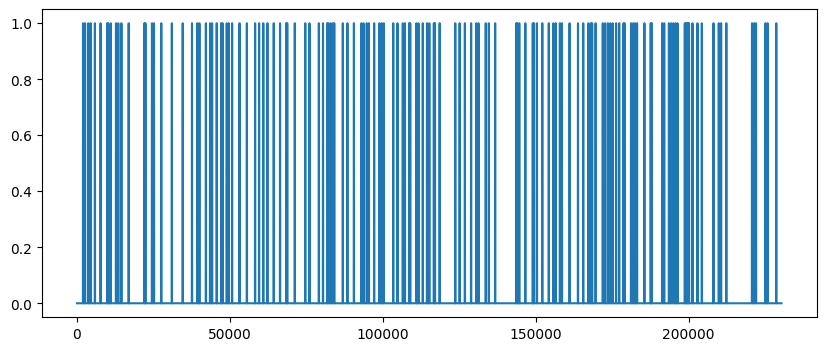

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(label)
plt.show()

## Highlight the anomalies in red

**Question:** Write a function that, given a time series and its label, creates a plot of the time series with its anomalies plotted with red on top of it.

**Hint:** Use matplotlib

In [6]:
# TODO: Implement the following function
def plot_signal_with_anomalies(x, y, title=None):
    plt.plot(x)
    
    holder = None
    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = i
        elif y[i] == 0 and holder:
            plt.plot(np.arange(holder, i), x[holder:i], color='red')
            holder = None

    if title:
        plt.title(title)

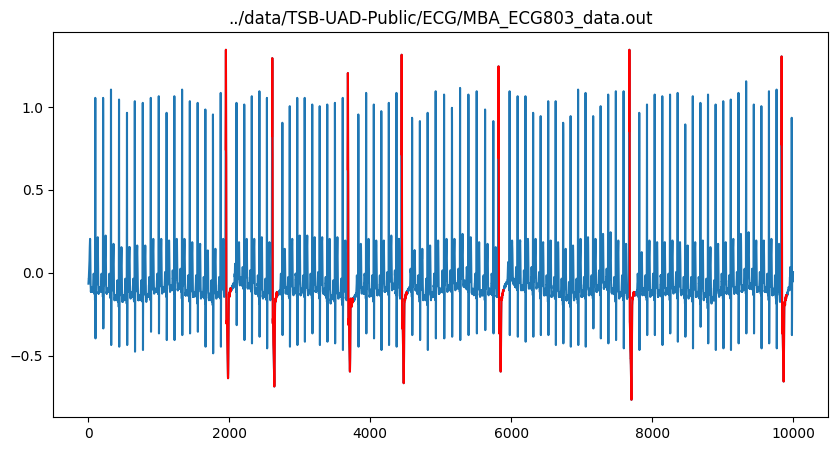

In [7]:
# Test your function here
x = data[:10000]
y = label[:10000]

plt.figure(figsize=(10, 5))
plot_signal_with_anomalies(x, y, title=file_path)
plt.show()

## Find the average number of anomalies for the whole dataset

**Question:** Write a function that, given the label of a time series, returns the number of anomalies found in the label.

**Example:** label = 100011111100001110001, expected output = 3 

In [8]:
# TODO: Implement the following function
def compute_number_of_anomalies(y):
    # Super-fast
    return np.sum(np.diff(y) == 1) + y[0]
    
    holder = None
    counter = 0
    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = i
            counter += 1
        elif y[i] == 0 and holder is not None:
            holder = None

    return counter
compute_number_of_anomalies(label)

147

### Load the whole ECG dataset

In [9]:
# List all files in the dataset directory with '.out' extension
files = [f for f in os.listdir(dataset_path) if f.endswith('.out')]
files_list = []

# Load them
for file_name in files:
    file_path = os.path.join(dataset_path, file_name)
    df = pd.read_csv(file_path, header=None)
    files_list.append({
        "dataset": "ECG",
        "file_name": file_name,
        "data": df[0].to_numpy(),
        "label": df[1].to_numpy(),
    })

### Compute the average number of anomalies in the ECG dataset

**Question:** Compute the average number of anomalies in the ECG dataset and print the result.

In [10]:
# TODO: Compute the average number of anomalies in all files
n_anomalies = 0

start = time.time()
for file in files_list:
    n_anomalies += compute_number_of_anomalies(file['label'])
end = time.time()

n_anomalies /= len(files)
time_slow = end - start

print(f"Average number of anomalies per file is {n_anomalies:.2f} computed in {time_slow:.2f} secs")

Average number of anomalies per file is 365.70 computed in 0.22 secs


# Detect anomalies
1. Run 5 detectors on the same time series, and collect their scores in the list of dictionaries called *scores*
2. Plot the anomaly scores along with the time series and its anomalies in subplots
3. Compute their accuracy, a) threshold-based, b) AUC-PR, c) VUR-PR
4. Discuss on what do you think is the best method?

## Setup

In [11]:
import math

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf
from scipy.signal import argrelextrema

from TSB_UAD.models.feature import Window

from TSB_UAD.models.norma import NORMA
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.pca import PCA
from TSB_UAD.models.poly import POLY
from TSB_UAD.models.ocsvm import OCSVM
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.AE_mlp2 import AE_MLP2
from TSB_UAD.models.cnn import cnn
from TSB_UAD.models.damp import DAMP
from TSB_UAD.models.sand import SAND

# Ignoring warning about deprecated function calls, use 'default' to see warnings
import warnings
warnings.filterwarnings('ignore')

2024-06-07 17:57:30.512369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-07 17:57:30.512422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Run 5 detectors and collect their scores

### Find the appropriate subsequence length for a time series

**Question:** Fill in the gaps in the following function.

**Hint:** You can run the function or uncomment the plot segment to verify your implementation.

In [12]:
def find_length(data):
    if len(data.shape) > 1:
        return 0
    data = data[:min(20000, len(data))]

    # Compute the autocorrelation and skip the very beginning
    base = 3
    auto_corr = acf(data, nlags=400, fft=True)
    auto_corr = auto_corr[base:]

    # Compute the local maxima of the aurocorrelation function
    local_max = argrelextrema(auto_corr, np.greater)[0]
    
    # global_max = local_max[np.argmax(auto_corr[local_max])]
    # plt.plot(auto_corr)
    # plt.scatter(local_max, auto_corr[local_max], color='red')
    # plt.scatter(global_max, auto_corr[global_max], color='green')

    try:
        max_local_max = np.argmax(auto_corr[local_max])
        if local_max[max_local_max] < 3 or local_max[max_local_max] > 300:
            return 125
        return local_max[max_local_max] + base
    except:
        return 125

find_length(data)

125

### Prepare the data for anomaly detection

In [13]:
# Extract the first 10000 points.
x = data[:10000]
y = label[:10000]

# Determine the appropriate length for the sliding window
slidingWindow = find_length(x)

# Convert the data into sliding windows
X_data = Window(window=slidingWindow).convert(x).to_numpy()

print("Estimated Subsequence length: ", slidingWindow)
print("Time series length: ", len(x))
print("Number of abnormal points: ", list(y).count(1))

Estimated Subsequence length:  108
Time series length:  10000
Number of abnormal points:  525


### Compute the scores and save the results in a list of dictionaries

**Question:** You should use the 5 classifiers, mentioned in the following 5 cells, to compute the anomaly score of x. The first classifier is already implemented. Repeat for the rest. You can go to the files '/TSB_UAD/models/*detector_name*.py' to check out the implementation of the detectors.

**Hint:** Make sure that the produced anomaly score, and the input time series, have the **same** length.

In [14]:
scores = []
model_name = 'DAMP'

start = time.time()
clf = DAMP(m=slidingWindow, sp_index=slidingWindow + 1)
clf.fit(x)
end = time.time()

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
    "execution_time": (end - start)
})

In [15]:
model_name='IForest'

# TODO: Repeat the same steps for IForest
start = time.time()
clf = IForest(n_jobs=1)
clf.fit(X_data)
end = time.time()

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
    "execution_time": (end - start)
})

In [16]:
model_name = 'NORMA'

# TODO: Repeat the same steps for Norma
start = time.time()
clf = NORMA(pattern_length=slidingWindow, nm_size=3 * slidingWindow)
clf.fit(x)
end = time.time()

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))
score = score[:x.shape[0]]

scores.append({
    "model_name": model_name,
    "score": score,
    "execution_time": (end - start)
})

In [17]:
model_name = 'MatrixProfile'

# TODO: Repeat the same steps for MatrixProfile
start = time.time()
clf = MatrixProfile(window = slidingWindow)
clf.fit(x)
end = time.time()

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
    "execution_time": (end - start)
})

In [18]:
model_name='PCA'

# TODO: Repeat the same steps for PCA
start = time.time()
clf = PCA()
clf.fit(X_data)
end = time.time()

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
    "execution_time": (end - start)
})

## Plot the anomaly scores

**Question:** Which method do you think is the best, and which is the worst? Why? You can write your answer in a cell below the plot.

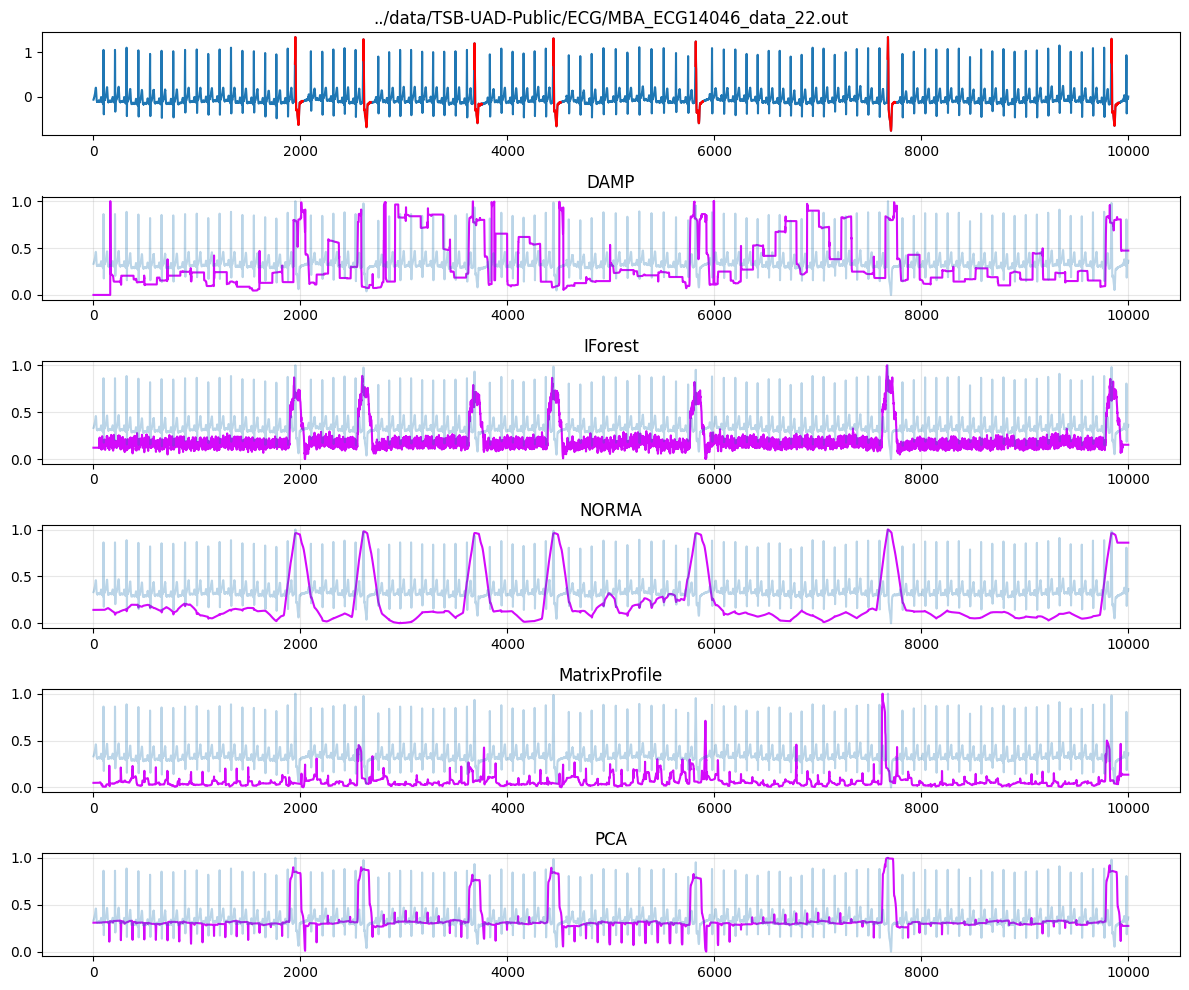

In [19]:
x_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(x.reshape(-1, 1)).ravel()

plt.figure(figsize=(12, 10))
plt.subplot(len(scores) + 1, 1, 1)
plot_signal_with_anomalies(x, y, title=file_path)

for i, elem in enumerate(scores):
    plt.subplot(len(scores) + 1, 1, i + 2)
    plt.title(elem['model_name'])
    plt.plot(elem['score'], color='#D30AFA')
    plt.plot(x_scaled, alpha=0.3)
    plt.grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

## Compute the accuracy

In [22]:
from sklearn.metrics import f1_score, precision_recall_curve, auc
from vus.metrics import get_metrics

### Find the threshold for each score and save it in the 'scores' list 

In [23]:
for i, elem in enumerate(scores):
    elem['threshold'] = elem['score'].mean() + (3 * elem['score'].std())

### Compute the F1-score for each score and save it

**Question:** Use the anomaly threshold we find above to compute the predicted label of 1s and 0s. Then, use it to compute the F1-score.

In [24]:
for i, elem in enumerate(scores):
    # elem['predicted_labels'] = ?
    # elem['f1_score'] = ?
    elem['predicted_labels'] = np.zeros(elem['score'].shape)
    elem['predicted_labels'][elem['score'] > elem['threshold']] = 1
    elem['f1_score'] = f1_score(y, elem['predicted_labels'])
    
for elem in scores: print(f'{elem["model_name"]}: {elem["f1_score"]}')

DAMP: 0.0
IForest: 0.6727089627391744
NORMA: 0.4907801418439717
MatrixProfile: 0.0
PCA: 0.6129334582942831


### Visualize the 5 scores along with their thresholds and F1-scores. What do you notice?

**Question:** Why IForest, Norma and PCA have different F1-scores, although they seem to have the same accuracy? Write your answer in a cell below the plot.

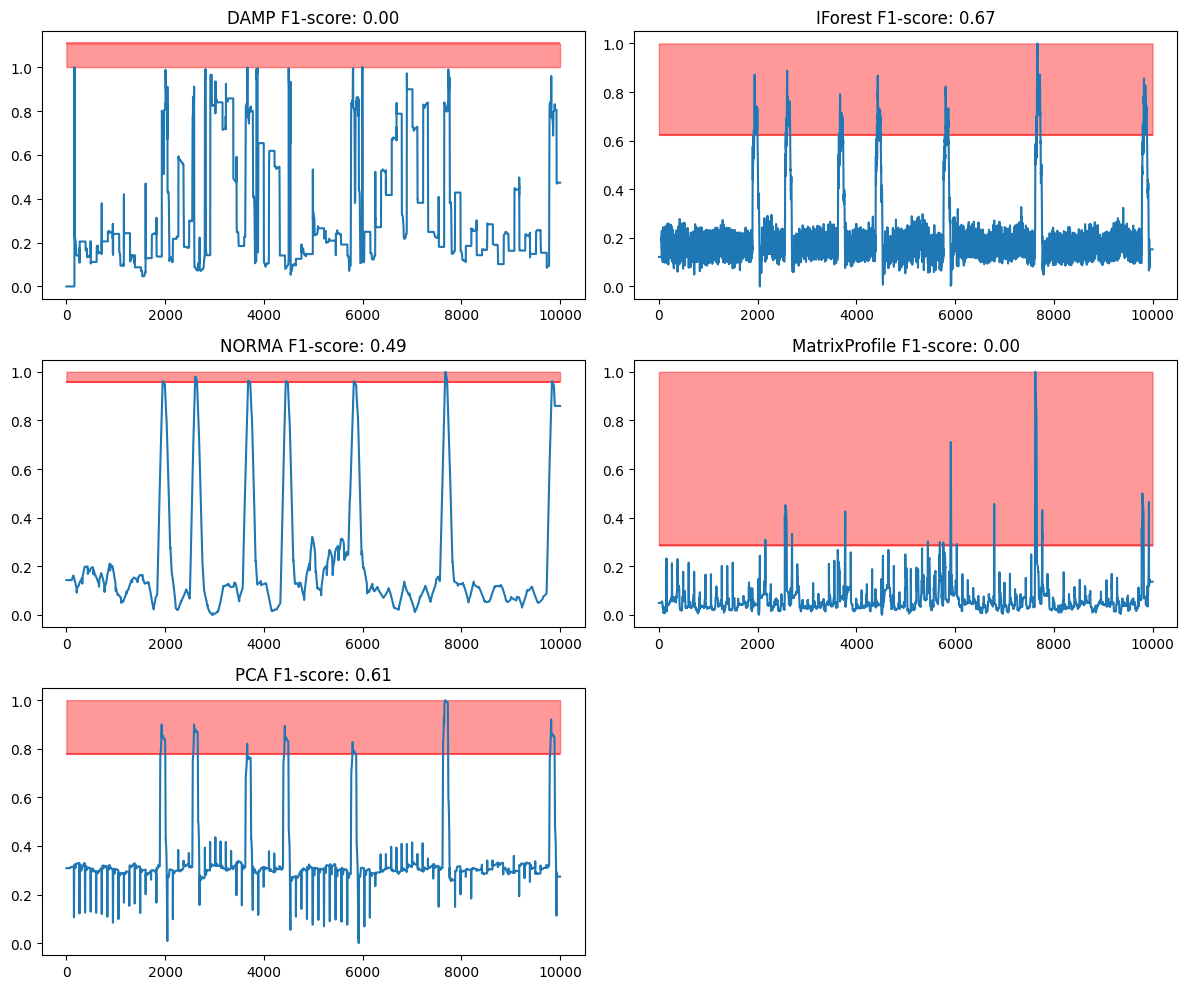

In [25]:
plt.figure(figsize=(12, 10))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.hlines(y=elem['threshold'], xmin=0, xmax=len(elem['score']), color='red', alpha=0.5)
    plt.fill_between(x=np.arange(0, len(elem['score'])), y1=elem['threshold'], y2=1, color='red', alpha=0.4)
    plt.plot(elem['score'])
    plt.title(f"{elem['model_name']} F1-score: {elem['f1_score']:.2f}")

plt.tight_layout()
plt.show()

### Compute Precision and Recall and save them

**Question:** Fill in the code that's missing. Compute precision and recall for multiple different thresholds and save them in the list of dictionaries.

In [26]:
for elem in scores:
    # elem['precision'], elem['recall'], elem['threshold_list'] = ?
    elem['precision'], elem['recall'], elem['threshold_list'] = precision_recall_curve(y, elem['score'])
    elem['threshold_list'] = [elem['threshold_list'][0]] + list(elem['threshold_list'])

### Plot Precision, Recall and the Precision-Recall curve

**Question:** Which method do you now think is the best, and why? Write your answer in a cell below the plot.

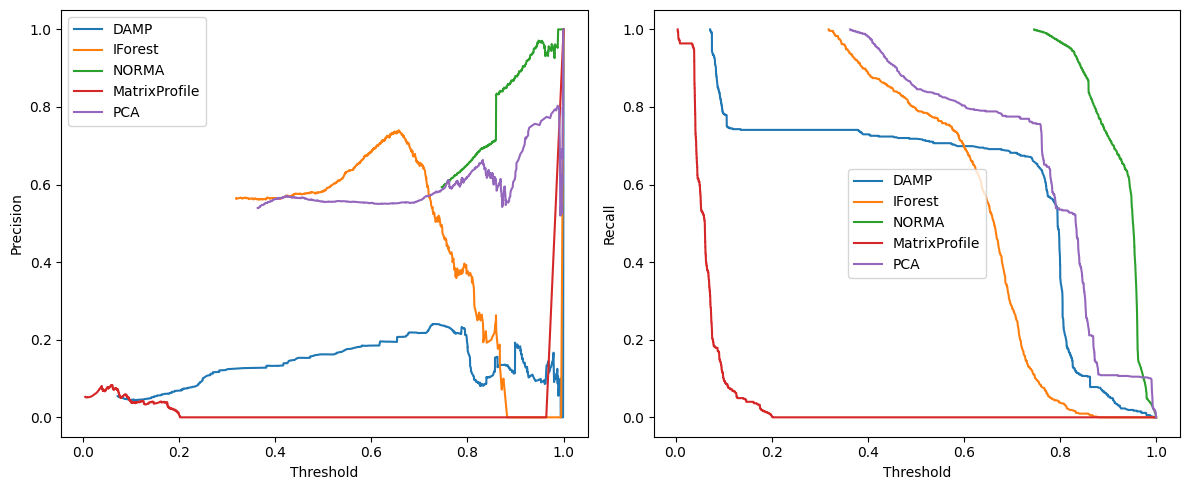

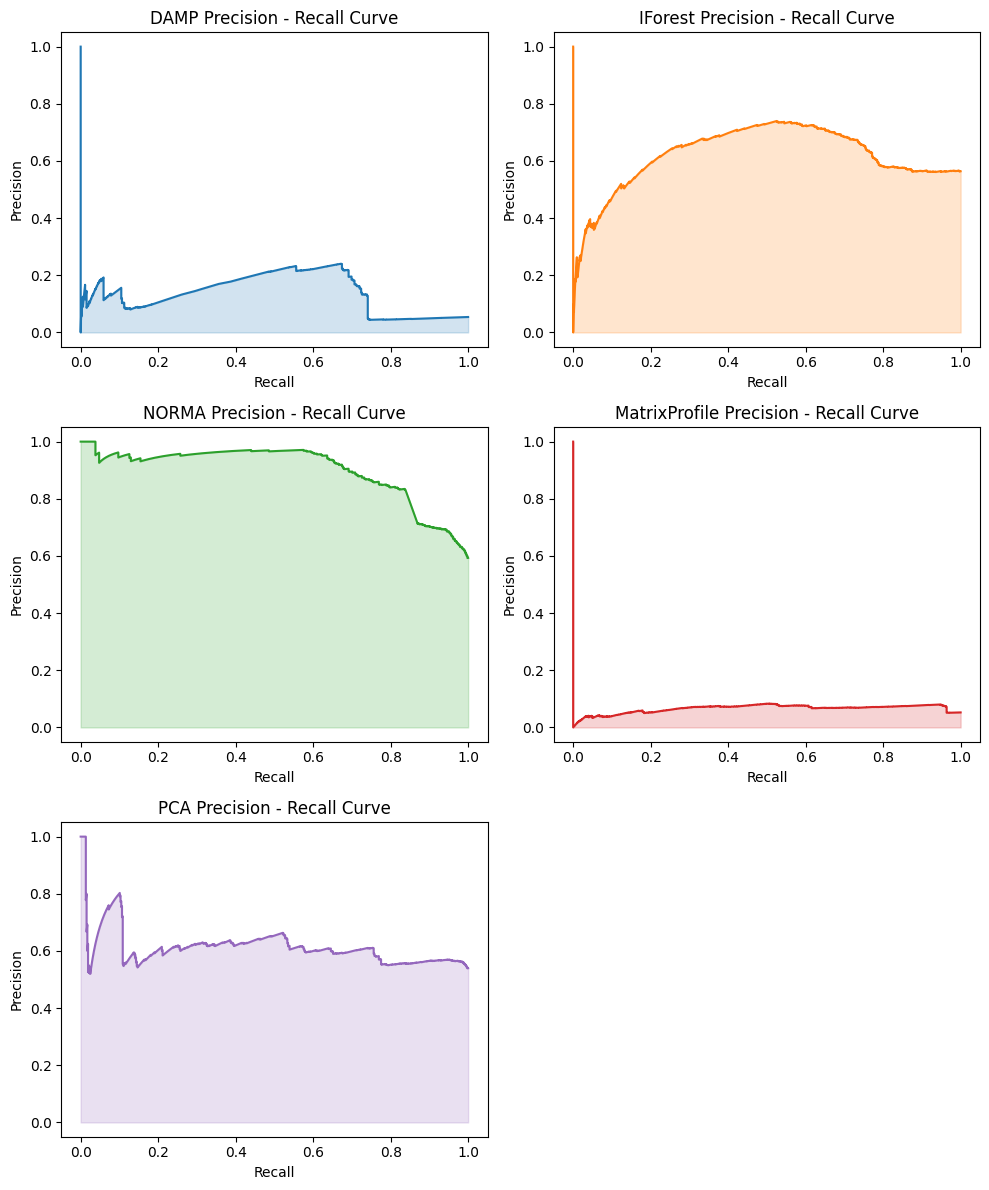

In [27]:
plt.figure(figsize=(12, 5))

# Plot Precision-Thresholds
plt.subplot(1, 2, 1)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['precision'], label=elem['model_name'])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.legend()

# Plot Recall-Thresholds
plt.subplot(1, 2, 2)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['recall'], label=elem['model_name'])
plt.ylabel('Recall')
plt.xlabel('Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 12))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.plot(elem['recall'], elem['precision'], label=elem['model_name'], color=f'C{i}')
    plt.fill_between(elem['recall'], 0, elem['precision'], alpha=0.2, color=f'C{i}')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(f"{elem['model_name']} Precision - Recall Curve")
plt.tight_layout()
plt.show()

### Compute AUC-PR

**Question:** Fill in the code that's missing. Compute the AUC-PR (Area Under the Precision-Recall Curve) score and save it in *scores*.

In [28]:
# Compute AUC-PR
for i, elem in enumerate(scores):
    # elem['AUC_PR'] = ?
    elem['AUC_PR'] = auc(elem['recall'], elem['precision'])

### Compute AUC-ROC, VUS-PR, VUS-ROC

**Question:** Use the *get_metrics* function from the *vus* library to compute the metrics AUC-ROC, VUS-PR, VUS-ROC. Save them in *scores*.

In [29]:
for elem in scores:
    # results = ?
    results = get_metrics(elem['score'], y, metric='all', slidingWindow=slidingWindow)
    for key in ['AUC_ROC', 'VUS_ROC', 'VUS_PR']:
        elem[key] = results[key]

In [30]:
df_scores = pd.DataFrame(scores)
df_scores[['model_name', 'f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC', 'execution_time']]

,model_name,f1_score,AUC_PR,AUC_ROC,VUS_PR,VUS_ROC,execution_time
0,DAMP,0.000000,0.135963,0.684105,0.262582,0.811980,101.185802
1,IForest,0.672709,0.613527,0.983632,0.882106,0.994051,2.579863
2,NORMA,0.490780,0.900552,0.994644,0.967042,0.997738,21.295915
3,MatrixProfile,0.000000,0.065553,0.628423,0.203553,0.773605,0.218500
4,PCA,0.612933,0.612886,0.980821,0.835664,0.990722,0.518377


### Visualize the results

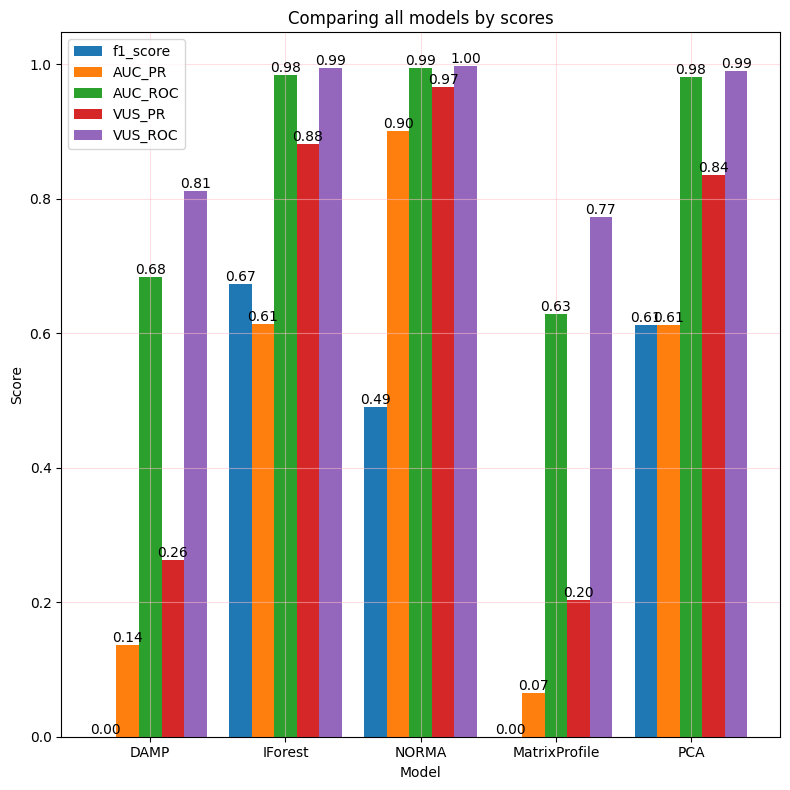

In [34]:
x = np.arange(0, len(df_scores['model_name']) * 3, 3)
bar_width = 0.5
results_show = ['f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC']
offsets = np.arange(len(results_show)) - (len(results_show) // 2)

fig, ax = plt.subplots(figsize=(8, 8))
for key, offset in zip(results_show, offsets):
    bars = ax.bar(x + (bar_width * offset), df_scores[key], bar_width, label=key)
    ax.bar_label(bars, labels=[f"{x:.2f}" for x in df_scores[key]])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparing all models by scores')
ax.set_xticks(x)
ax.set_xticklabels(df_scores['model_name'])
ax.legend()

plt.grid(color='pink', alpha=0.5)
plt.tight_layout()
plt.show()

### Measure Execution Time

**Question:** Rerun the anomaly detectors and compute execution time. Then create the same bar plot as above but for execution time and compare the detectors.

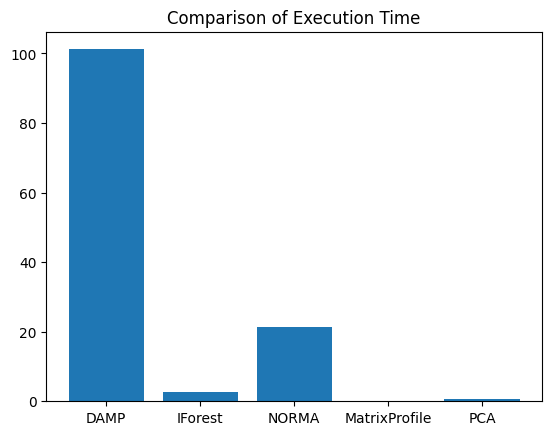

In [35]:
# TODO: Bar plot for execution time
plt.bar(
    height=df_scores['execution_time'], 
    x=np.arange(len(df_scores['execution_time'])), 
    tick_label=df_scores['model_name']
)
plt.title('Comparison of Execution Time')
plt.show()

# Analyse datasets

The following part of this session is **optional**.
1. Load three datasets
2. Run 5 detectors on each
3. Plot the AUC-PR and VUS-PR boxplots
4. What's the best detector now? Is there a best detector? Does this apply to all the time series of the dataset?

In [36]:
from tqdm import tqdm
from TSB_UAD.models.distance import Fourier

tqdm.pandas()

## Load the datasets

In [40]:
# Add the paths of the datasets we are going to analyse and compare
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public')
datasets = ['SMD', 'SensorScope', 'MGAB']
dataset_paths = {}

for dataset in datasets:
    dataset_paths.update({
        dataset: os.path.join(dataset_path, dataset)
    })

In [41]:
# List all files in the dataset directory with '.out' extension
files_list = []
new_files_list = []
timeseries_len = 5000

for dataset in dataset_paths.keys():
    files_list.extend([{
    "dataset": dataset,
    "file_name": f,
} for i, f in enumerate(os.listdir(dataset_paths[dataset])) if f.endswith('.out') and i%2])

# Load them
for file in files_list:
    file_path = os.path.join(dataset_paths[file['dataset']], file['file_name'])
    df = pd.read_csv(file_path, header=None)
    tmp_data = df[0].to_numpy()
    tmp_label = df[1].to_numpy()

    # Find indices of anomalies
    anomaly_indices = np.where(tmp_label == 1)[0]
    
    if len(anomaly_indices) > 0:
        start_idx = max(0, anomaly_indices[0] - (timeseries_len // 2))
        end_idx = min(len(tmp_data), start_idx + timeseries_len)
        
        # Adjust start index if end index exceeds data length
        start_idx = max(0, end_idx - timeseries_len)
        
        file.update({
            "data": tmp_data[start_idx:end_idx],
            "label": tmp_label[start_idx:end_idx],
        })
        new_files_list.append(file)
    
df = pd.DataFrame(new_files_list)
df

,dataset,file_name,data,label
0,SMD,machine-2-4.test.csv@10.out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,SMD,machine-2-8.test.csv@5.out,"[0.978967, 0.978967, 0.978967, 0.978967, 0.978...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,SMD,machine-1-1.test.csv@12.out,"[0.027027, 0.013514, 0.013514, 0.027027, 0.027...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,SMD,machine-3-11.test.csv@36.out,"[0.630863, 0.625223, 0.619907, 0.621824, 0.624...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,SMD,machine-3-1.test.csv@20.out,"[0.198278, 0.196732, 0.193344, 0.190667, 0.192...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
151,MGAB,2.test.out,"[1.2837287659722465, 1.2913226225534586, 1.296...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
152,MGAB,9.test.out,"[0.5406142968203491, 0.6226104157852361, 0.724...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
153,MGAB,8.test.out,"[0.922658231896791, 0.9100058962426456, 0.8962...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
154,MGAB,10.test.out,"[0.8865385134852068, 0.9678188584569276, 1.041...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Run the Anomaly Detectors

### Prepare the data

In [42]:
df['sliding_window'] = df['data'].apply(find_length)
df['x_sub'] = df.progress_apply(lambda x: Window(window = x['sliding_window']).convert(x['data']).to_numpy(), axis=1)

100%|█████████████████████████████████████████| 156/156 [00:04<00:00, 34.79it/s]


## Run 5 detectors and collect their scores

**Question:** In each one of the function defined below, fill in the missing commands to create and fit the appropriate classifier according to the function's name.

In [43]:
def norm_score(score, sliding_window):
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    score = np.array([score[0]] * math.ceil((sliding_window - 1) / 2) + list(score) + [score[-1]] * ((sliding_window - 1) // 2))
    return score

def run_NORMA(x, sliding_window):
    # TODO: Create and fit the classifier
    clf = NORMA(pattern_length=sliding_window, nm_size=(3 * sliding_window))
    clf.fit(x)
    
    return norm_score(clf.decision_scores_, sliding_window)[:x.shape[0]]
    
def run_POLY(x, sliding_window):
    # TODO: Create and fit the classifier
    clf = POLY(power=3, window=sliding_window)
    clf.fit(x)
    
    measure = Fourier()
    measure.detector = clf
    measure.set_param()
    
    clf.decision_function(measure=measure)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()

    return score

def run_PCA(x_sub, sliding_window):
    # TODO: Create and fit the classifier
    clf = PCA()
    clf.fit(x_sub)
    
    return norm_score(clf.decision_scores_, sliding_window)

def run_IForest(x_sub, sliding_window):
    # TODO: Create and fit the classifier
    clf = IForest(n_jobs=1)
    clf.fit(x_sub)
    
    return norm_score(clf.decision_scores_, sliding_window)

def run_OCSVM(X_train, X_test, sliding_window):
    X_train_ = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_train.T).T
    X_test_ = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_test.T).T
    
    # TODO: Create and fit the classifier
    clf = OCSVM(nu=0.05)
    clf.fit(X_train_, X_test_)
    
    return norm_score(clf.decision_scores_, sliding_window)

In [44]:
# Run the 5 detectors in all time series. This should take about 3 minutes
df['NORMA_score'] = df.progress_apply(lambda x: run_NORMA(x['data'], x['sliding_window']), axis=1)
df['POLY_score'] = df.progress_apply(lambda x: run_POLY(x['data'], x['sliding_window']), axis=1)
df['PCA_score'] = df.progress_apply(lambda x: run_PCA(x['x_sub'], x['sliding_window']), axis=1)
df['IForest_score'] = df.progress_apply(lambda x: run_IForest(x['x_sub'], x['sliding_window']), axis=1)
df['OCSVM_score'] = df.progress_apply(lambda x: run_OCSVM(x['x_sub'][:int(0.1*len(x['x_sub']))], x['x_sub'], x['sliding_window']), axis=1)

  0%|                                                   | 0/156 [00:00<?, ?it/s]A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.
100%|█████████████████████████████████████████| 156/156 [00:05<00:00, 29.40it/s]


## Compute & Plot the AUC-PR in boxplots

In [45]:
detectors = [
    'POLY',
    'PCA',
    'IForest',
    'NORMA',
    'OCSVM'
]

# Compute metrics for every detectors' score and every time series
for detector in detectors:
    auc = df.progress_apply(lambda x: get_metrics(x[f'{detector}_score'], x['label'], metric='auc', slidingWindow=x['sliding_window']), axis=1)
    auc_pr = [x['AUC_PR'] for x in auc.to_list()]
    df[f'{detector}_AUC_PR'] = auc_pr

100%|████████████████████████████████████████| 156/156 [00:00<00:00, 388.94it/s]


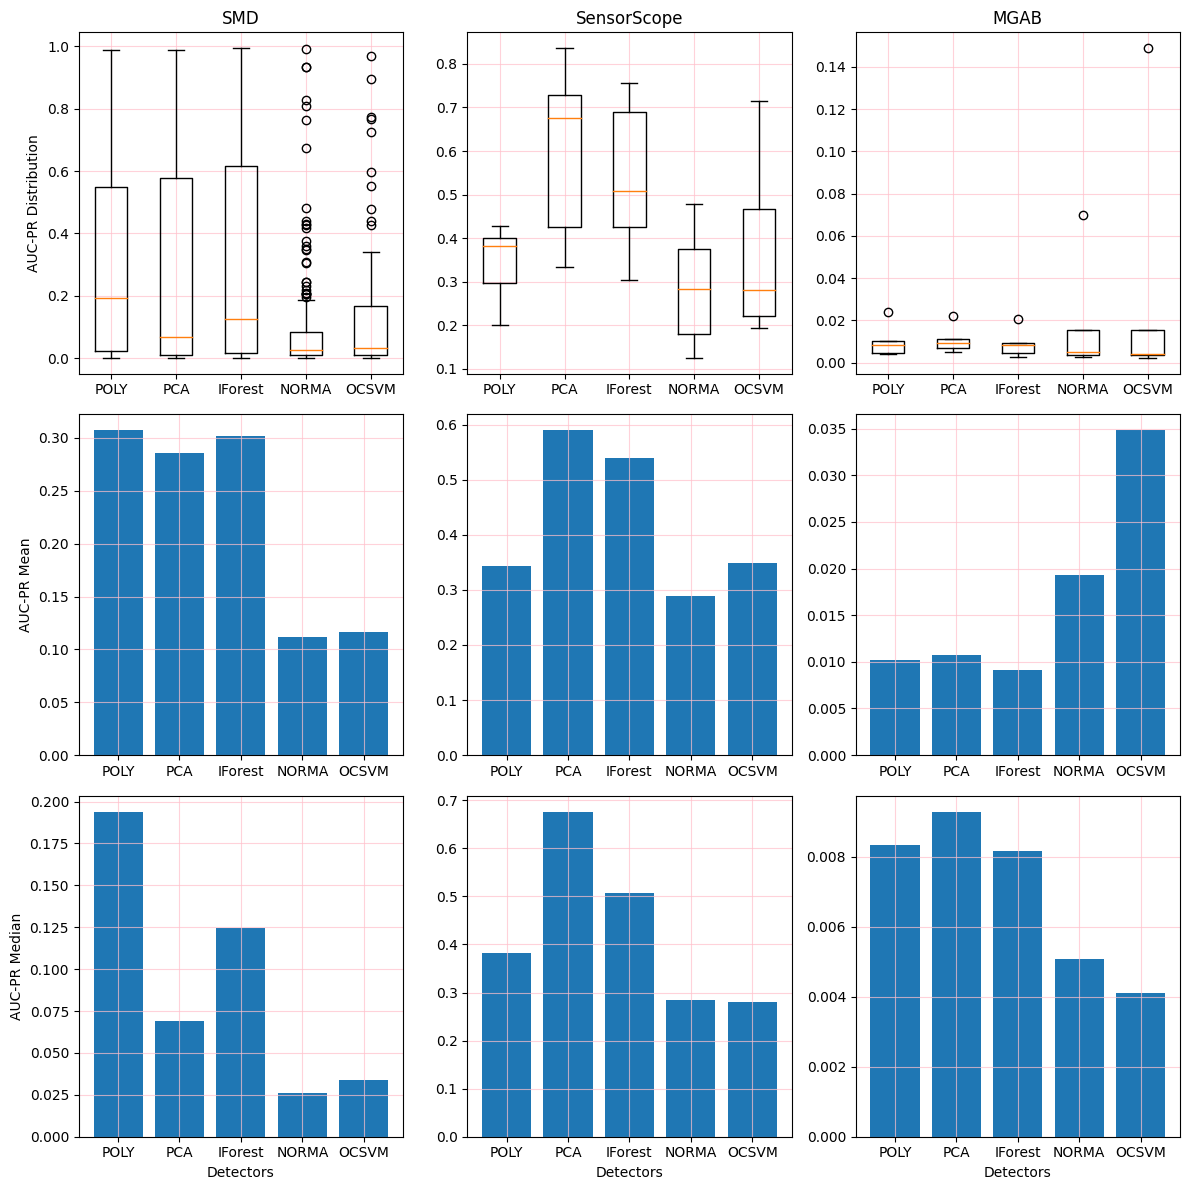

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None
    axes[0, i].grid(alpha=0.7, color='pink')

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None
    axes[1, i].grid(alpha=0.7, color='pink')

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].grid(alpha=0.7, color='pink')
    axes[2, i].set_xlabel('Detectors')

plt.tight_layout()
plt.show()

# Bonus question: Can we do better ?
1. Averaging Ensemble
2. Model Selection

## Compute Averaging Ensemble score, its AUC-PR and put it in the box plot.

**Question:** Compute the Averaging Ensemble, that is the average of the anomaly scores that we computed before. Save it in the dataframe.

In [47]:
# Drop 'AVG_ENS_score' column if it exists, in case we run this cell more than once
if 'AVG_ENS_score' in df.columns:
    df = df.drop('AVG_ENS_score', axis=1)

scores_df = df.filter(like='_score')

# TODO: Calculate the averaging ensemble for each time series
# df['AVG_ENS_score'] = ?
df['AVG_ENS_score'] = scores_df.apply(lambda row: np.mean(np.vstack(row.values), axis=0), axis=1)

In [48]:
auc = df.progress_apply(lambda x: get_metrics(x['AVG_ENS_score'], x['label'], metric='auc', slidingWindow=x['sliding_window']), axis=1)
auc_pr = [x['AUC_PR'] for x in auc.to_list()]
df['AVG_ENS_AUC_PR'] = auc_pr

100%|████████████████████████████████████████| 156/156 [00:00<00:00, 310.81it/s]


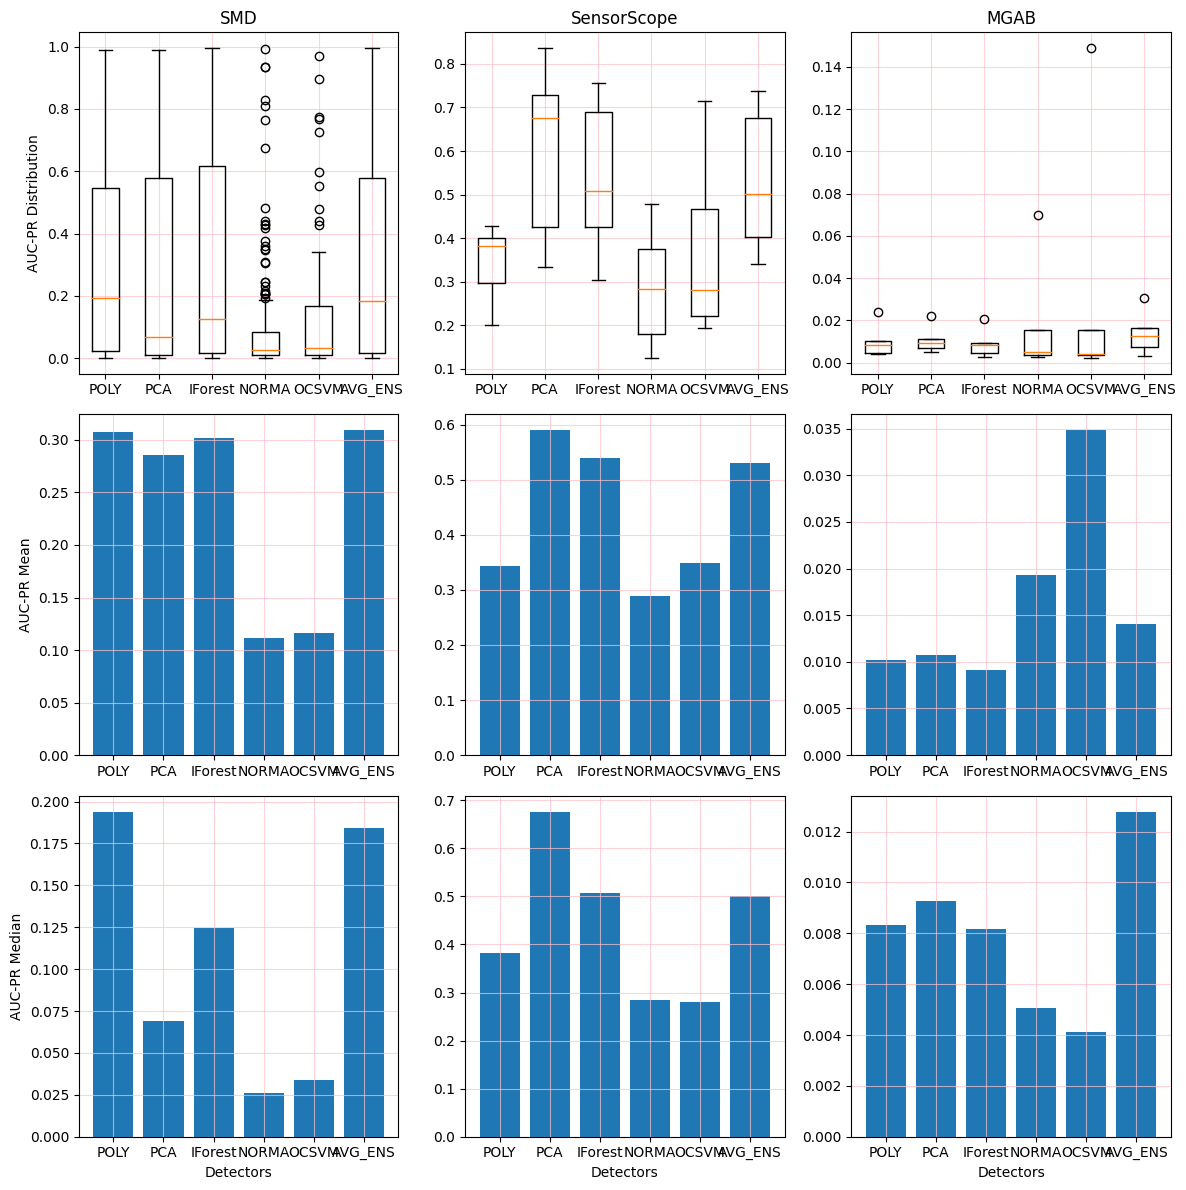

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None
    axes[0, i].grid(alpha=0.7, color='pink')

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None
    axes[1, i].grid(alpha=0.7, color='pink')

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].grid(alpha=0.7, color='pink')
    axes[2, i].set_xlabel('Detectors')

plt.tight_layout()
plt.show()

## Model Selection

**Question:** Can we do better than that? Clone the MSAD repository and evaluate a pretrained model (or train it from scratch :) ), on the datasets we saw here.